# The Best and Worst Pitchers in MLB History

In [1]:
import pandas as pd
pitching = pd.read_csv("../baseballdatabank-2023.1/core/Pitching.csv")

Data courtesy of [Sean Lahman's Baseball](http://www.seanlahman.com/download-baseball-database)

In [2]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

In [3]:
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,7,NaN,0,146.0,0,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,7,NaN,0,1291.0,0,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,2,NaN,0,14.0,0,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,20,NaN,0,1080.0,1,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,0,NaN,0,57.0,0,21,NaN,NaN,NaN


In [4]:
pitching.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')

## Calculating Pitcher Totals

We'll group by `playerID` to be able to work with career statistics *per pitcher*.

In [5]:
pitchers = pitching.groupby('playerID').sum()

In [6]:
pitchers.sample(8)

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,,,,,
sardilu01,4033,2,0,0,2,0,0,0,0,6,...,0.0,0,0.0,0,7.0,2,0,0.0,0.0,0.0
parrijo01,18045,10,14,14,183,16,0,0,1,833,...,14.0,23,10.0,0,1278.0,44,156,7.0,13.0,33.0
woodrbr01,12117,6,41,25,119,104,1,0,1,1840,...,1.0,7,26.0,1,2474.0,4,226,8.0,10.0,39.0
eubanue01,1922,1,0,0,2,0,0,0,0,5,...,0.0,1,0.0,0,16.0,0,9,0.0,0.0,0.0
jacobto01,3903,2,0,0,2,0,0,0,0,12,...,0.0,0,0.0,0,22.0,1,5,0.0,0.0,0.0
moscogu01,10055,5,13,14,70,26,0,0,0,668,...,4.0,14,8.0,1,956.0,11,119,2.0,5.0,12.0
breinfr01,9910,5,27,20,140,42,8,0,1,1311,...,30.0,8,9.0,5,1864.0,32,191,39.0,19.0,30.0
barera01,9874,5,16,26,88,49,9,3,1,1020,...,14.0,8,1.0,0,1492.0,18,206,15.0,11.0,41.0


## Restoring Year

This has ruined our `yearID` column! We'll want to have a sense of *when* our pitchers pitched later (see below), so let's now add a column that will record a pitcher's *first year* in the Major Leagues.

In [7]:
pitchers['firstYear'] = pitching.groupby('playerID').agg({'yearID': 'min'})

In [8]:
pitchers.sample(8)

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,firstYear
playerID,,,,,,,,,,,,,,,,,,,,,
paulsgi01,1925,1,0,0,1,0,0,0,0,6,...,0,0.0,0,8.0,1,0,0.0,0.0,0.0,1925
guzmage01,4001,2,5,4,17,10,0,0,0,209,...,3,2.0,0,296.0,0,40,3.0,1.0,9.0,2000
toolest01,7551,4,27,26,55,52,49,1,0,1329,...,41,29.0,1,2030.0,3,356,0.0,0.0,0.0,1886
pomerst01,2012,1,0,0,3,0,0,0,0,18,...,0,0.0,0,26.0,0,2,0.0,0.0,0.0,2012
jonesmi02,7930,4,11,10,71,25,0,0,0,676,...,4,3.0,0,996.0,25,125,7.0,11.0,13.0,1980
kobayma01,4017,2,4,5,67,0,0,0,6,196,...,5,2.0,0,289.0,36,39,1.0,1.0,7.0,2008
carroja01,2013,1,0,0,1,0,0,0,0,3,...,0,0.0,0,3.0,1,0,0.0,0.0,0.0,2013
smithch07,10060,5,1,4,77,9,0,0,0,444,...,4,4.0,0,642.0,27,93,2.0,6.0,10.0,2008


## Adding a WHIP Column

Now then: How shall we measure pitching prowess? There are of course many statistics we might use, but a good one is **WHIP**: **W**alks plus **H**its divided by **I**nnings **P**itched.

We'll have to create this as a new column since it doesn't exist per se in our data. But we can calculate it. Note that our data includes `IPouts` rather than `IP`, where `IP` * 3 = `IPouts`.

In [9]:
pitchers['WHIP'] = 3 * (pitchers['BB'] + pitchers['IBB'] + pitchers['H']) / pitchers['IPouts']

In [10]:
pitchers['WHIP'].sample(10)

playerID
colemdy01    1.224215
jordaha01    1.615385
niekrjo01    1.339007
marshru01    1.561983
pattoha01    1.500000
simonal01    1.419355
torrelu01    1.500000
veachal01    2.900000
smithbu02    1.500000
ritteha01    1.318966
Name: WHIP, dtype: float64

## Plotting the WHIP Distribution

We'll need to drop the infinite values (from those pitchers who appeared in games but never got an out!).

In [11]:
finite_whips = pitchers[pitchers['WHIP'] != np.inf]

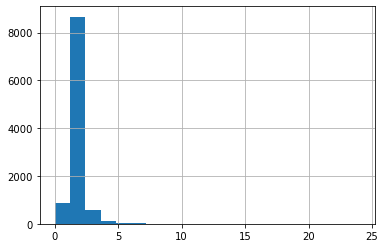

In [12]:
finite_whips['WHIP'].hist(bins=20);

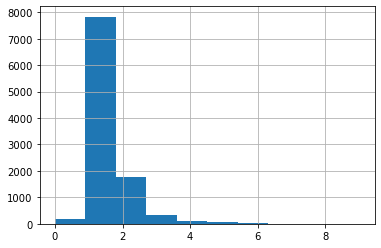

In [13]:
finite_whips[finite_whips['WHIP'] < 10]['WHIP'].hist();

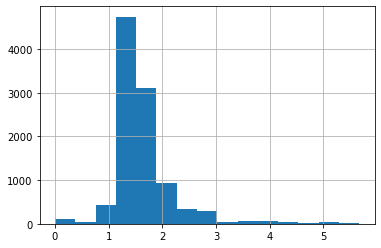

In [14]:
finite_whips[finite_whips['WHIP'] < 6]['WHIP'].hist(bins=15);

This distribution looks much like a **Poisson** Distribution, which is appropriate, since in effect we're talking about predicting a number of events (walks or hits) in a certain amount of time (an inning). The conjugate prior for a Poisson Distribution is a **Gamma** Distribution.

## Typical WHIP

In [15]:
# Average over every pitcher's career

finite_whips['WHIP'].mean()

1.6728769083535022

Let's go with 1.67 as our ordinary WHIP. This will serve as our Bayesian prior, although we'll still need to make a choice about how many innings (and walks + hits) to use as our baseline.

## Going Bayesian: Adding a `MAP_WHIP` column

We can't just look directly at WHIPs, since some pitchers' stats will be misleadingly low or misleadingly high: If someone pitched two innings over their whole career and didn't give up a hit or a walk, that pitcher would have a career WHIP of 0, but that doesn't make him the greatest pitcher of all time.

In [16]:
pitchers.sort_values(['WHIP', 'IPouts'], ascending=[True, False]).head()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,HBP,BK,BFP,GF,R,SH,SF,GIDP,firstYear,WHIP
playerID,,,,,,,,,,,,,,,,,,,,,
braital01,1915,1,0,0,2,0,0,0,0,9,...,0.0,0,0.0,1,0,0.0,0.0,0.0,1915,0.0
gickge01,3875,2,0,0,2,0,0,0,1,9,...,1.0,0,10.0,1,0,0.0,0.0,0.0,1937,0.0
tayloed01,1903,1,0,0,1,0,0,0,0,9,...,0.0,0,12.0,1,0,0.0,0.0,0.0,1903,0.0
rosscl01,1954,1,0,0,4,0,0,0,1,8,...,0.0,0,8.0,3,0,0.0,0.0,0.0,1954,0.0
davisch01,1993,1,0,0,1,0,0,0,0,6,...,1.0,0,7.0,1,0,0.0,0.0,0.0,1993,0.0


The man at the top here is [Al Braithwood](https://www.baseball-reference.com/players/b/braital01.shtml). Ever heard of him? No, because, even though he has a career WHIP of 0, he only ever pitched three innings!

So we need some kind of baseline to compare pitchers against. This is why we calculated an average WHIP. This baseline will serve as our Bayesian prior, and, because of the nature of conjugacy, all we need to do is to add this baseline to existing data to calculate a posterior.

Let's see what we get if we use 100 innings and 160 walks + hits, and look for the best adjusted WHIPs of all time.

In [17]:
pitchers['MAP_WHIP'] = 3 * (pitchers['BB'] + pitchers['IBB'] + pitchers['H'] + 167) / (pitchers['IPouts'] + 300)

In [18]:
pitchers.sort_values('MAP_WHIP', ascending=True).head()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,BK,BFP,GF,R,SH,SF,GIDP,firstYear,WHIP,MAP_WHIP
playerID,,,,,,,,,,,,,,,,,,,,,
jossad01,17154,9,160,97,286,260,234,45,5,6981,...,1,8891.0,22,730,0.0,0.0,0.0,1902,0.967770,0.996704
walshed01,26747,14,195,126,430,315,250,57,35,8893,...,14,11500.0,104,873,0.0,0.0,0.0,1904,0.999550,1.021429
kershcl01,30225,15,197,87,401,398,25,15,0,7743,...,22,10160.0,1,777,90.0,29.0,177.0,2008,1.011623,1.036181
janseke01,26208,13,42,28,766,0,0,0,391,2307,...,11,3040.0,573,225,6.0,15.0,21.0,2010,0.957087,1.039125
ueharko01,20128,11,22,26,436,12,0,0,95,1442,...,0,1862.0,207,153,11.0,9.0,14.0,2009,0.909154,1.040184


At the top there is [Addie Joss](https://www.baseball-reference.com/players/j/jossad01.shtml), a real legend of the early game.

## Trying Different Starting Numbers

In [19]:
def whip_prior(wh, ipouts, ascending=False, number=10, data=pitchers):
    """
    This function takes in a number of hits plus walks and a number of
    innings to use as prior values for the Bayesian MAP Method. It returns
    the top (worst) hitter according to the MAP average. The ratio
    of hits plus walks to innings should be (near) 167:100. By default it finds
    the *worst* pitchers. To find the best, set the `ascending` parameter
    to True. 
    """
    data['MAP_WHIP'] = 3 * (data['BB'] + data['IBB'] + data['H'] + wh) / (data['IPouts'] + ipouts)
    return data.sort_values('MAP_WHIP', ascending=ascending).head(number)

Let's try this function out!

In [20]:
whip_prior(16.7, 30)

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,BK,BFP,GF,R,SH,SF,GIDP,firstYear,WHIP,MAP_WHIP
playerID,,,,,,,,,,,,,,,,,,,,,
lewis01,1890,1,0,1,1,1,0,0,0,9,...,0,29.0,0,20,0.0,0.0,0.0,1890,6.666667,2.823077
haasbr01,1915,1,0,1,6,2,1,0,0,43,...,0,85.0,1,27,0.0,0.0,0.0,1915,3.558140,2.782192
traveal01,1912,1,0,1,1,1,1,0,0,24,...,0,50.0,0,24,0.0,0.0,0.0,1912,4.125000,2.761111
martipa02,1955,1,0,1,7,1,0,0,0,21,...,1,49.0,3,12,0.0,0.0,0.0,1955,4.285714,2.747059
bullore01,1936,1,0,2,12,2,0,0,0,50,...,0,108.0,3,32,0.0,0.0,0.0,1936,3.360000,2.726250
williac01,3886,2,0,0,6,0,0,0,0,27,...,0,61.0,4,17,0.0,0.0,0.0,1940,3.888889,2.721053
bradyji01,1956,1,0,0,6,0,0,0,0,19,...,0,43.0,3,21,0.0,0.0,0.0,1956,4.263158,2.675510
vonfrto01,1890,1,0,1,1,1,1,0,0,24,...,0,55.0,0,16,0.0,0.0,0.0,1890,3.875000,2.650000
dixonst01,3987,2,0,0,6,0,0,0,0,15,...,0,38.0,0,16,2.0,1.0,1.0,1993,4.600000,2.646667


## Proceeding Systematically

We'll grab the worst pitcher for lots of different starting numbers of innings pitched.

In [21]:
worsts = {}
for ipouts in range(10, 10001, 10):
    worsts[ipouts] = whip_prior(ipouts*167/300, ipouts, number=1).iloc[0].name

In [22]:
set(worsts.values())

{'flythst01', 'haasbr01', 'lewis01', 'mcmuljo01', 'stechch01', 'wadswja01'}

For different numbers of innings we get different pitchers with the highest WHIP.

In [23]:
pitcher_with_ip = {}
for ipout_num in worsts:
    if worsts[ipout_num] not in pitcher_with_ip:
        pitcher_with_ip[worsts[ipout_num]] = ipout_num

In [24]:
pitcher_with_ip

{'lewis01': 10,
 'haasbr01': 40,
 'flythst01': 80,
 'stechch01': 180,
 'mcmuljo01': 770,
 'wadswja01': 1000}

Presumably, pitching only 10 or even 80 outs is not enough to feel confident that we are dealing with the worst pitcher. Once we get up to 180 outs, we meet [William Stecher](https://www.baseball-reference.com/players/s/stechch01.shtml).

In [25]:
pitchers[pitchers.index == 'stechch01']

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,BK,BFP,GF,R,SH,SF,GIDP,firstYear,WHIP,MAP_WHIP
playerID,,,,,,,,,,,,,,,,,,,,,
stechch01,1890,1,0,10,10,10,9,0,0,204,...,0,386.0,0,110,0.0,0.0,0.0,1890,2.514706,1.686887


At 770 outs, we encounter [John McMullin](https://www.baseball-reference.com/players/m/mcmuljo01.shtml), who died all the way back in 1881 (!).

In [26]:
pitchers[pitchers.index == 'mcmuljo01']

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,BK,BFP,GF,R,SH,SF,GIDP,firstYear,WHIP,MAP_WHIP
playerID,,,,,,,,,,,,,,,,,,,,,
mcmuljo01,7491,4,14,15,37,31,30,0,1,850,...,0,1513.0,5,405,0.0,0.0,0.0,1871,2.008235,1.696498


## Looking for Pitchers after 1900

There were some rule changes before 1900 that changed the game quite a lot. In the 19th century there were restrictions on pitching that we wouldn't recognize today -- restrictions that made it quite difficult for pitchers to excel. So we might bracket pitchers whose earliest years were in the 19th century. Let's see what happens if we do that.

In [27]:
pitchers20th = pitchers.copy()
pitchers20th = pitchers20th[pitchers20th['firstYear'] > 1900]

In [28]:
worsts = {}
for ipouts in range(10, 10001, 10):
    worsts[ipouts] = whip_prior(ipouts*167/300, ipouts, number=1, data=pitchers20th).iloc[0].name

In [29]:
set(worsts.values())

{'clearjo01',
 'flythst01',
 'haasbr01',
 'martipa02',
 'sweetle01',
 'walkuji02',
 'weikdi01'}

In [30]:
pitcher_with_ip = {}
for ipout_num in worsts:
    if worsts[ipout_num] not in pitcher_with_ip:
        pitcher_with_ip[worsts[ipout_num]] = ipout_num

In [31]:
pitcher_with_ip

{'clearjo01': 10,
 'martipa02': 20,
 'haasbr01': 30,
 'flythst01': 80,
 'weikdi01': 480,
 'walkuji02': 2680,
 'sweetle01': 6230}

In this way we find [Stu Flythe](https://www.baseball-reference.com/players/f/flythst01.shtml) and [Dick Weik](https://www.baseball-reference.com/players/w/weikdi01.shtml), both of whom are in the running for the worst Major League pitcher of all time.

## Distinguishing Between Starters and Relievers

Another distinction we might like to draw is between starting pitchers and relief pitchers. This has been an important part of the game for nearly a century.

Probably this will be especially relevant when we look for the *best* pitchers, since managers tend to tolerate higher WHIPs for their starters than for their relievers.

In [32]:
pitchers.columns

Index(['yearID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts',
       'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB', 'WP', 'HBP', 'BK',
       'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP', 'firstYear', 'WHIP', 'MAP_WHIP'],
      dtype='object')

How shall we determine whether a pitcher was a reliever or not? Probably the easiest way is to take advantage of the `GS` (**G**ames **S**tarted) statistic. What we can do is to compare that statistic with the `G` (**G**ames) statistic. If a sufficiently low percentage of games in which a pitcher appeared are games that that pitcher started, then we can feel safe in classifying that pitcher as a reliever.

So: How low is sufficiently low? Let's try a ratio of 1/4. If less than one quarter of the games in which a pitcher appeared are games that the pitcher started, then we'll call that pitcher a reliever.

(There are some subtleties here (pitchers transitioning from starter to reliever or the reverse, pitchers with very low counts of games in the first place, etc.), but I think we can safely ignore these complications for now.)

In [33]:
pitchers20th['reliever'] = pitchers20th['GS'] / pitchers20th['G'] < 0.25

In [34]:
pitchers20th.head()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,BFP,GF,R,SH,SF,GIDP,firstYear,WHIP,MAP_WHIP,reliever
playerID,,,,,,,,,,,,,,,,,,,,,
aardsda01,18084,9,16,18,331,0,0,0,69,1011,...,1475.0,141,169,17.0,11.0,21.0,2004,1.486647,1.653165,True
aasedo01,25786,13,66,60,448,91,22,5,82,3328,...,4730.0,235,503,50.0,34.0,106.0,1977,1.430589,1.610219,True
abadfe01,22164,12,8,29,400,6,0,0,2,1045,...,1481.0,101,155,7.0,12.0,28.0,2010,1.337799,1.638569,True
abbotco01,4043,2,0,5,23,10,0,0,0,196,...,298.0,9,45,1.0,2.0,0.0,2021,1.530612,1.667321,False
abbotgl01,23743,13,62,83,248,206,37,5,0,3858,...,5508.0,13,707,60.0,39.0,111.0,1973,1.388025,1.591499,False


In [35]:
starters = pitchers20th.copy()
starters = starters[starters['reliever'] == False]

relievers = pitchers20th.copy()
relievers = relievers[relievers['reliever'] == True]

In [36]:
worst_starters = {}
for ipouts in range(10, 10001, 10):
    worst_starters[ipouts] = whip_prior(ipouts*167/300, ipouts, number=1, data=starters).iloc[0].name

In [37]:
set(worst_starters.values())

{'haasbr01', 'pennha01', 'sweetle01', 'traveal01', 'walkuji02', 'weikdi01'}

In [38]:
pitcher_with_ip = {}
for ipout_num in worst_starters:
    if worst_starters[ipout_num] not in pitcher_with_ip:
        pitcher_with_ip[worst_starters[ipout_num]] = ipout_num

In [39]:
pitcher_with_ip

{'traveal01': 10,
 'haasbr01': 30,
 'pennha01': 250,
 'weikdi01': 260,
 'walkuji02': 2680,
 'sweetle01': 6230}

We see Dick Weik again, but a name that didn't show up before is that of [Hayden Penn](https://www.baseball-reference.com/players/p/pennha01.shtml). But Weik is the worst starter for 260 IP_outs all the way up to 2670 IP_outs, so he's my pick for the worst starter in the history of the Major Leagues.

![img](https://www.baseball-reference.com/req/202303230/images/headshots/a/af48bbb6_davis.jpg)

Image from baseball-reference.com

In [40]:
worst_relievers = {}
for ipouts in range(10, 10001, 10):
    worst_relievers[ipouts] = whip_prior(ipouts*167/300, ipouts, number=1, data=relievers).iloc[0].name

In [41]:
set(worst_relievers.values())

{'bullore01', 'clearjo01', 'flythst01', 'marshcu01', 'martipa02'}

In [42]:
pitcher_with_ip = {}
for ipout_num in worst_relievers:
    if worst_relievers[ipout_num] not in pitcher_with_ip:
        pitcher_with_ip[worst_relievers[ipout_num]] = ipout_num

In [43]:
pitcher_with_ip

{'clearjo01': 10,
 'martipa02': 20,
 'bullore01': 40,
 'flythst01': 70,
 'marshcu01': 820}

Surely, 820 IP_outs is more than enough for a good baseline. And so we see once again [Stu Flythe](https://www.baseball-reference.com/players/f/flythst01.shtml), who is my pick for the worst reliever in the history of the Major Leagues.

![img](https://www.baseball-reference.com/req/202303230/images/headshots/e/eef0c0d3_davis.jpg)

Image from baseball-reference.com

## Best Starters and Relievers

In [44]:
best_starters = {}
for ipouts in range(10, 10001, 10):
    best_starters[ipouts] = whip_prior(ipouts*167/300, ipouts, number=1, ascending=True, data=starters).iloc[0].name

In [45]:
set(best_starters.values())

{'hennira01', 'johnswa01', 'jossad01', 'walshed01'}

In [46]:
pitcher_with_ip = {}
for ipout_num in best_starters:
    if best_starters[ipout_num] not in pitcher_with_ip:
        pitcher_with_ip[best_starters[ipout_num]] = ipout_num

In [47]:
pitcher_with_ip

{'hennira01': 10, 'jossad01': 30, 'walshed01': 1870, 'johnswa01': 2010}

The best starter of all time is very arguably [Addie Joss](https://baseball-reference.com/players/j/jossad01.shtml).

![img](https://www.baseball-reference.com/req/202303230/images/headshots/5/5e51b2e7_sabr.jpg)

Image from baseball-reference.com

In [48]:
best_relievers = {}
for ipouts in range(10, 10001, 10):
    best_relievers[ipouts] = whip_prior(ipouts*167/300, ipouts, number=1, ascending=True, data=relievers).iloc[0].name

In [49]:
set(best_relievers.values())

{'barriyh01', 'janseke01', 'riverma01', 'ueharko01', 'wilheho01'}

In [50]:
pitcher_with_ip = {}
for ipout_num in best_relievers:
    if best_relievers[ipout_num] not in pitcher_with_ip:
        pitcher_with_ip[best_relievers[ipout_num]] = ipout_num

In [51]:
pitcher_with_ip

{'barriyh01': 10,
 'ueharko01': 20,
 'janseke01': 300,
 'riverma01': 830,
 'wilheho01': 2970}

Here the decision is a bit more difficult. But arguably, a sufficient number of IP_outs pitched to be confident in our choice is less than 300, in which case our choice for the greatest reliever of all time will be [Koji Uehara](https://www.baseball-reference.com/players/u/ueharko01.shtml).

![img](https://www.baseball-reference.com/req/202303230/images/headshots/e/e109d804_mlbam.jpg)

Image from baseball-reference.com